In [15]:
from utils.train import GAN
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import torch
from sklearn.metrics import mean_squared_error

# plt.style.use('dark_background')
trainer = pl.Trainer()
inspect(trainer.logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


╭───────────── <class 'pytorch_lightning.loggers.tensorboard.TensorBoardLogger'> ─────────────╮
│ Log to local file system in `TensorBoard <https://www.tensorflow.org/tensorboard>`_ format. │
│                                                                                             │
│ ╭─────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ <pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7fcf424ab050>      │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                             │
│        experiment = <torch.utils.tensorboard.writer.SummaryWriter object at 0x7fcf43abf390> │
│   group_separator = '/'                                                                     │
│           hparams = {}                                                                      │
│           log_dir = '/home/xusj/code/Stock-Prediction/lightning_logs/version_33'            │
│  LOGGER_JOIN_CHAR = '-'                                                                     │
│              name = 'lightning_logs'                                                        │
│ NAME_HPARAMS_FILE = 'hparams.yaml'                                                          │
│          root_dir = '/home/xusj/code/Stock-Prediction/lightning_logs'                       │
│          save_dir = '/home/xusj/code/Stock-Prediction'                                      │
│           sub_dir = None                                                                    │
│           version = 33                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────╯

In [29]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='val_RMSE',
    dirpath='./model_checkpoint',
    filename='GAN-{v_num}-{epoch:02d}-{step:02d}-{val_RMSE:.2f}',
    save_top_k=3,
)

trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trainer.callbacks[-1] is checkpoint_callback

True

In [25]:
checkpoint_callback.filename += f"-v{trainer.logger.version}"

In [31]:
checkpoint_callback

In [30]:
trainer.checkpoint_callback

# Train

In [51]:
model = GAN(30, 1)

prepare_data
Apple (1507, 29)


In [6]:
model = GAN.load_from_checkpoint('trainer.ckpt')

In [ ]:
trainer.fit(model=model, ckpt_path='lightning_logs/version_0/checkpoints/epoch=26804-step=214440.ckpt')

In [5]:
trainer.fit(model)

prepare_data

Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/3


Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/3


Apple (1507, 29)


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/3
Missing logger folder: logs/GAN
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 3 processes
----------------------------------------------------------------------------------------------------

Missing logger folder: logs/GAN
Missing logger folder: logs/GAN
/home/xusj/miniconda3/envs/torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /home/xusj/code/Stock-Prediction/model_checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name      | Type          | Params
--------------------------------------------
0 | G         | Generator     | 9.

Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s] 

/home/xusj/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/conv.py:309: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,
/home/xusj/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/conv.py:309: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,
/home/xusj/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/conv.py:309: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it, v_num=0, lossG=0.683, lossD=1.390]


In [6]:
trainer.save_checkpoint('trainer.ckpt')

# Test

In [2]:
ckpt_path = 'model_checkpoint/epoch=859-step=18920.ckpt'
model = GAN.load_from_checkpoint(ckpt_path)
model.eval()
model.freeze()
X, Y = model.dataset[:]
y_pred = model(X.to(model.device))
y_true = model.raw_dataset.y_scaler.inverse_transform(Y[:, model.num_days_for_predict].cpu()).flatten()
y_pred = model.raw_dataset.y_scaler.inverse_transform(y_pred.cpu()).flatten()

In [3]:
split = int(len(y_pred)*0.8)
y_train_pred, y_test_pred = y_pred[:split], y_pred[split:]
y_train, y_test = y_true[:split], y_true[split:]
train_RMSE = mean_squared_error(y_train, y_train_pred, squared=False)
test_RMSE = mean_squared_error(y_test, y_test_pred, squared=False)
standard_RMSE = mean_squared_error(y_true[1:], y_true[:-1], squared=False)
train_standard_RMSE = mean_squared_error(y_train[1:], y_train[:-1], squared=False)
test_standard_RMSE = mean_squared_error(y_test[1:], y_test[:-1], squared=False)
print("train RMSE:", train_RMSE)
print("test RMSE:", test_RMSE)
print("standard RMSE:", standard_RMSE)
print("train standard RMSE:", train_standard_RMSE)
print("test standard RMSE:", test_standard_RMSE)
print("train RMSE / standard RMSE:", train_RMSE/train_standard_RMSE)
print("test RMSE / standard RMSE:", test_RMSE/test_standard_RMSE)


train RMSE: 5.43976926560915
test RMSE: 10.169652556409961
standard RMSE: 2.316641005189636
train standard RMSE: 2.1648560890732442
test standard RMSE: 2.828606700678385
train RMSE / standard RMSE: 2.5127625309901624
test RMSE / standard RMSE: 3.5952868788619403


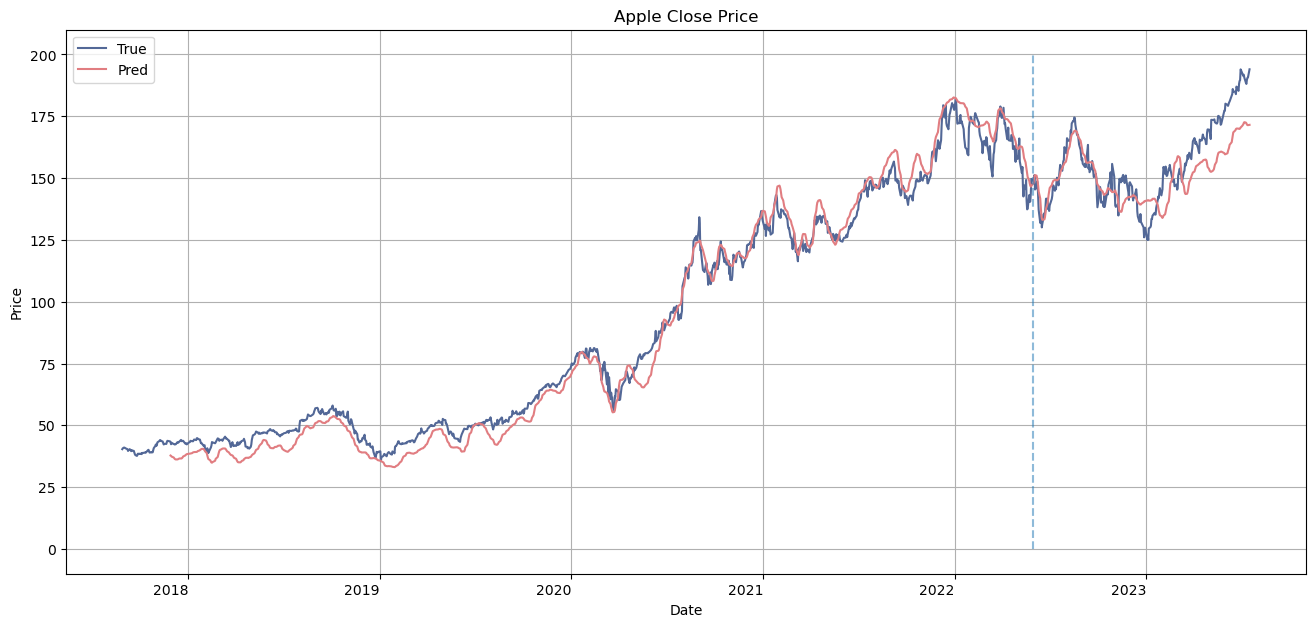

In [4]:
target = 'Apple'

df = model.raw_dataset.df
df['Apple Close Pred'] = None
df.iloc[-len(y_pred):, -1] = y_pred
df['Apple Close'].plot(figsize=(16,8),label=f'True', color='#536897')
df['Apple Close Pred'].plot(figsize=(16,8),label=f'Pred', color='#E17D81', rot=0)

split = df.index[int(len(df) * .8)]
plt.plot((split, split), (0, 200), linestyle='--', alpha=0.5)
plt.grid()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{target} Close Price')
plt.show()